In [1]:
import jax 
from jax import numpy as jnp
import chex
import gymnax
from gymnax.environments.environment import EnvState, Environment, EnvParams

from typing import Tuple, Any, Callable
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

In [6]:
from model import (
    DQNTrainingArgs, DQNTrainState,
    DQN, DQNParameters, DQNAgent,
    select_action, compute_loss, update_target,
    initialize_agent_state,
    compute_loss_double_dqn,
    SimpleDQNAgent,
    DoubleDQNAgent
)
from buffer import ReplayBuffer, ReplayBufferStorage, FIFOBuffer
from trainer import agent_iteration

In [7]:
seeds_dqn = {}

In [8]:
for SEED in tqdm(range(40, 51)):
    args = DQNTrainingArgs()
    rng = jax.random.key(SEED)
    rng, agent_init_rng = jax.random.split(rng, 2)
    # create the agent and its optimization state
    agent_state = SimpleDQNAgent.initialize_agent_state(SimpleDQNAgent.dqn, agent_init_rng, args)
    # create the environment
    env, env_params = gymnax.make('CartPole-v1')
    def env_reset(rng: chex.PRNGKey) -> Tuple[chex.Array, EnvState]:
        return env.reset(rng, env_params)
    def env_step(rng: chex.PRNGKey, env_state: EnvState, action: chex.Array) -> Tuple[chex.Array, EnvState]:
        return env.step(rng, env_state, action, env_params)
    state_shape = env.observation_space(env_params).shape
    n_actions = env.action_space().n
    # create replay buffer storage
    buffer_state = FIFOBuffer.init_buffer(buffer_size=args.fifo_buffer_size, state_shape=state_shape)
    # reset the environment to start working with it
    rng, reset_rng = jax.random.split(rng, 2)
    obs, env_state = env_reset(reset_rng)
    environment_step = jnp.array(0, dtype=jnp.int32)

    # now we define the main function to update the agent and compile it
    agent_iter = partial(agent_iteration, args, SimpleDQNAgent, FIFOBuffer, env_reset, env_step)
    # donate_argnums=(2,) tells jax to optimize all operations with replay buffer
    # and do them in-place
    # the cost of this to that we need to recompile it every time we reinitialize the agent
    # (because some functions get recreated). we could avoid this at the cost of much 
    # more complicated implementation.
    agent_iter = jax.jit(agent_iter, donate_argnums=(2,)).lower(
        # states
        rng, agent_state, buffer_state, env_state,
        # inputs
        obs, environment_step
    ).compile()
    losses = []
    steps = []
    returns = []
    while environment_step < args.sample_budget:
        rng, agent_state, buffer_state, env_state, obs, environment_step, dqn_losses, eval_returns = agent_iter(
            # configuration and randomness
            # args, SimpleDQNAgent, FIFOBuffer, env_step,
            # states
            rng, agent_state, buffer_state, env_state,
            # inputs
            obs, environment_step
        )
        # print(environment_step)
        steps.append(environment_step)
        returns.append(eval_returns)
        losses.append(dqn_losses)
        # return returns, losses
    seeds_dqn[SEED] = (steps, returns)

100%|██████████| 11/11 [04:07<00:00, 22.50s/it]


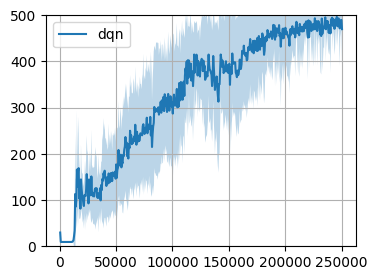

In [9]:
plt.figure(figsize=(4,3))
plt.tight_layout()
mean_return = np.stack([seeds_dqn[k][1] for k in seeds_dqn.keys()]).mean(0)
std_return = np.stack([seeds_dqn[k][1] for k in seeds_dqn.keys()]).std(0)
plt.plot(steps, mean_return, label='dqn')
plt.fill_between(steps, mean_return - std_return, mean_return + std_return, alpha=0.3)
plt.ylim(0, 500)
plt.grid()
plt.legend()
plt.savefig('dqn.pdf')

In [11]:
np.mean(mean_return[-100:]), np.std(mean_return[-100:])

(np.float32(473.93796), np.float32(12.44198))

In [ ]:
seeds_ddqn = {}

In [ ]:
for SEED in tqdm(range(40, 51)):
    args = DQNTrainingArgs()
    rng = jax.random.key(SEED)
    rng, agent_init_rng = jax.random.split(rng, 2)
    # create the agent and its optimization state
    agent_state = DoubleDQNAgent.initialize_agent_state(DoubleDQNAgent.dqn, agent_init_rng, args)
    # create the environment
    env, env_params = gymnax.make('CartPole-v1')
    def env_reset(rng: chex.PRNGKey) -> Tuple[chex.Array, EnvState]:
        return env.reset(rng, env_params)
    def env_step(rng: chex.PRNGKey, env_state: EnvState, action: chex.Array) -> Tuple[chex.Array, EnvState]:
        return env.step(rng, env_state, action, env_params)
    state_shape = env.observation_space(env_params).shape
    n_actions = env.action_space().n
    # create replay buffer storage
    buffer_state = FIFOBuffer.init_buffer(buffer_size=args.fifo_buffer_size, state_shape=state_shape)
    # reset the environment to start working with it
    rng, reset_rng = jax.random.split(rng, 2)
    obs, env_state = env_reset(reset_rng)
    environment_step = jnp.array(0, dtype=jnp.int32)

    # now we define the main function to update the agent and compile it
    agent_iter = partial(agent_iteration, args, DoubleDQNAgent, FIFOBuffer, env_reset, env_step)
    # donate_argnums=(2,) tells jax to optimize all operations with replay buffer
    # and do them in-place
    # the cost of this to that we need to recompile it every time we reinitialize the agent
    # (because some functions get recreated). we could avoid this at the cost of a bit 
    # more complicated implementation.
    agent_iter = jax.jit(agent_iter, donate_argnums=(2,)).lower(
        # states
        rng, agent_state, buffer_state, env_state,
        # inputs
        obs, environment_step
    ).compile()
    losses = []
    steps = []
    returns = []
    while environment_step < args.sample_budget:
        rng, agent_state, buffer_state, env_state, obs, environment_step, dqn_losses, eval_returns = agent_iter(
            # states
            rng, agent_state, buffer_state, env_state,
            # inputs
            obs, environment_step
        )
        # print(environment_step)
        steps.append(environment_step)
        returns.append(eval_returns)
        losses.append(dqn_losses)
        # return returns, losses
    seeds_ddqn[SEED] = (steps, returns)

In [ ]:
plt.figure(figsize=(4,3))
plt.tight_layout()
mean_return = np.stack([seeds_dqn[k][1] for k in seeds_dqn.keys()]).mean(0)
std_return = np.stack([seeds_dqn[k][1] for k in seeds_dqn.keys()]).std(0)
plt.plot(steps, mean_return, label='dqn')
plt.fill_between(steps, mean_return - std_return, mean_return + std_return, alpha=0.3)

mean_return = np.stack([seeds_ddqn[k][1] for k in seeds_ddqn.keys()]).mean(0)
std_return = np.stack([seeds_ddqn[k][1] for k in seeds_ddqn.keys()]).std(0)
plt.plot(steps, mean_return, label='double-dqn')
plt.fill_between(steps, mean_return - std_return, mean_return + std_return, alpha=0.3)

plt.ylim(0, 500)
plt.grid()
plt.legend()
plt.savefig('double-dqn.pdf')